In [1]:
import os
import time
import PIL
import numpy as np
import pandas as pd
import itertools
from glob import glob
from PIL import Image
import random
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(888)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [78]:
'''
This module intend to implement map-style data loader
'''
class ImageData(Dataset):
    def __init__(self, landscape_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.landscape_dir = landscape_dir
        self.photo_dir = photo_dir
        self.landscape_idx = dict()
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, j in enumerate(os.listdir(self.landscape_dir)):
            try: 
                self.landscape_idx[i] = j
            except:
                pass
        for i, j in enumerate(os.listdir(self.photo_dir)):
            
            try:
                self.photo_idx[i] = j
            except:
                pass

    def __getitem__(self, idx):
        i = int(np.random.uniform(0, len(self.photo_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[i])
        landscape_path = os.path.join(self.landscape_dir, self.landscape_idx[i])
        photo_img = Image.open(photo_path).convert('RGB') 
        photo_img = self.transform(photo_img)
        landscape_img = Image.open(landscape_path).convert('RGB') 
        landscape_img = self.transform(landscape_img)
        return photo_img, landscape_img

    def __len__(self):
        return min(len(self.landscape_idx.keys()), len(self.photo_idx.keys()))

In [100]:
painting_path = './data/paintings/Harvard/'
sketch_path = './data/sketch/photo/'

In [101]:
#read data from disk
images_data = ImageData(painting_path,sketch_path)
images_loader = DataLoader(images_data, batch_size=1, pin_memory=True)
photo_img,landscape_img = next(iter(images_loader))

In [102]:
def unnorm(img, mean=[0.5, 0.5,0.5], std=[0.5, 0.5,0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

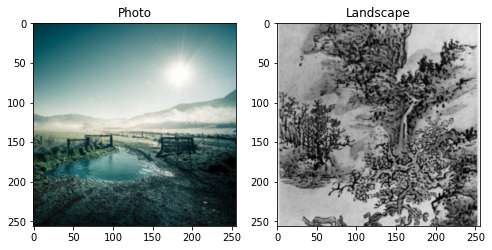

In [103]:
'''
rearranges the original tensor according to the desired ordering 
and returns a new multidimensional rotated tensor
'''
figure = plt.figure(figsize=(8, 8))

figure.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

figure.add_subplot(1, 2, 2)
plt.title('Landscape')
landscape_img = unnorm(landscape_img)
plt.imshow(landscape_img[0].permute(1, 2, 0))

In [9]:
def load_checkpoint(path, map_location=None):
    checkpoint = torch.load(path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % path)
    return checkpoint
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

## Model - Generator


In [10]:
'''
For generator model, first build the downsample and upsample functions, 
where upsample increase the dimension of the images 
and downsample do the opposite.
'''

def downsample(in_channel, out_channel, apply_dropout=True):
    downsample_model = []
    downsample_model.append(nn.Conv2d(in_channel, out_channel, 3, stride=2, padding=1, output_padding=1))
    downsample_model.append(nn.InstanceNorm2d(out_channel))
    if apply_dropout:
        downsample_model.append(nn.Dropout(0.5))
    downsample_model.append(nn.ReLU())
    
    return nn.Sequential(*downsample)

def upsample(in_channel, out_channel, apply_dropout=True):
    upsample_model = []
    upsample_model.append(nn.ConvTranspose2d(in_channel, out_channel, 3, stride=2, padding=1, output_padding=1))
    upsample_model.append(nn.InstanceNorm2d(out_channel))
   
    if apply_dropout:
        upsample_model.append(nn.Dropout(0.5))
    upsample_model.append(nn.ReLU())
    
    return nn.Sequential(*upsample_model)


In [11]:
def Conv_2(in_channel, out_channel, kernels=3, stride=2, leaky=True, inst_norm=True, pad=True):
    model = []
    
    if pad:
        model.append(nn.Conv2d(in_channel, out_channel, kernels, stride, 1, bias=True))  
    else:
        model.append(nn.Conv2d(in_channel, out_channel, kernels, stride, 0, bias=True))

    if inst_norm:
        model.append(nn.InstanceNorm2d(out_channel))
    else:
        model.append(nn.BatchNorm2d(out_ch))
        
    if leaky:
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
    else:
        model.append(nn.ReLU())

    return nn.Sequential(*model)

In [12]:
'''
Residual Blocks are skip-connection blocks that learn 
residual functions with reference to the layer inputs, 
instead of learning unreferenced functions.
'''
class ResidualBlock(nn.Module):
    def __init__(self, dim, apply_dropout=True):
        super().__init__()
        self.conv1 = Conv_2(dim, dim, kernels=3, stride=1, leaky=False, inst_norm=True,pad=True)
        self.conv2 = Conv_2(dim,dim, kernels=3, stride=1, leaky=False, inst_norm=True,pad=True)

    def forward(self, x):
        out_1 = F.relu(self.conv1(x))
        out_2 = x + self.conv2(out_1)
        return out_2

In [13]:
'''
Generator Model:
'''
class Generator(nn.Module):
    def __init__(self, in_chanel, out_chanel, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Conv_2(in_chanel, 64, 7, 1, False, True, False))
        model.append(Conv_2(64, 128, 3, 2, False))
        model.append(Conv_2(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(ResidualBlock(256))
        model.append(upsample(256, 128))
        model.append(upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_chanel, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.generate = nn.Sequential(*model)

    def forward(self, x):
        return self.generate(x)

In [14]:
'''
Discriminator Model:
'''
class Discriminator(nn.Module):
    def __init__(self, in_chanel, n=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_chanel, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, n):
            in_chanel = 64 * 2**(i-1)
            out_chanel = in_chanel * 2
            if i == n -1:
                model.append(Conv_2(in_chanel, out_chanel, 4, 1))
            else:
                model.append(Conv_2(in_chanel, out_chanel, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

## Additional Functions

In [15]:
def weights_init(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    Param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    
    std = 0.02
    mean = 0.0
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1):
        init.normal_(m.weight.data, mean, std)

In [16]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [17]:
'''
Referrencing https://arxiv.org/pdf/1612.07828.pdf
Save 50 generated fake imgs and sample through them
to feed discriminators to avoid large oscillations 
from iterations to iterations.
'''

class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [18]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [19]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

## CycleGAN

In [83]:
lr=0.0002 
beta1=0.5  #exponential decay rate for the first moment estimates
beta2=0.999 #exponential decay rate for the second-moment estimates

class CycleGAN(object):
    def __init__(self, in_chanel, out_chanel, epochs, device,lr=2e-4, lmbda=10, idt_coef=0.5):
        self.epochs = epochs
        self.decay_epoch = int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen1 = Generator(in_chanel, out_chanel)
        self.gen2 = Generator(in_chanel, out_chanel)
        self.disc1 = Discriminator(in_chanel)
        self.disc2 = Discriminator(in_chanel)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen1.parameters(), self.gen2.parameters()),
                                         lr = lr, betas=(beta1, beta2))
        self.adam_disc = torch.optim.Adam(itertools.chain(self.disc1.parameters(), self.disc2.parameters()),
                                          lr=lr, betas=(beta1, beta2))
        self.sample_l = sample_fake()
        self.sample_p = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        disc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.disc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_disc, disc_lr.step)
        self.gen_stats = AvgStats()
        self.disc_stats = AvgStats()
        
    def init_models(self):
        weights_init(self.gen1)
        weights_init(self.gen2)
        weights_init(self.disc1)
        weights_init(self.disc2)
        self.gen1 = self.gen1.to(self.device)
        self.gen2 = self.gen2.to(self.device)
        self.disc1 = self.disc1.to(self.device)
        self.disc2 = self.disc2.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_disc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (p, l) in enumerate(t):
                photo_img, landscape_img = p.to(device), l.to(device) #load real images
                update_req_grad([self.disc1, self.disc2], False)
                
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_p = self.gen1(landscape_img)
                fake_l = self.gen2(photo_img)

                cycl_l = self.gen2(fake_p)
                cycl_p = self.gen1(fake_l)

                id_l = self.gen2(landscape_img)
                id_p = self.gen1(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_l = self.l1_loss(id_l, landscape_img) * self.lmbda * self.idt_coef
                idt_loss_p = self.l1_loss(id_p, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_l = self.l1_loss(cycl_l, landscape_img) * self.lmbda
                cycle_loss_p = self.l1_loss(cycl_p, photo_img) * self.lmbda

                disc_l = self.disc1(fake_l)
                disc_p = self.disc2(fake_p)

                real = torch.ones(disc_l.size()).to(self.device)

                adv_loss_l = self.mse_loss(disc_l, real)
                adv_loss_p = self.mse_loss(disc_p, real)

                # compute total generator loss and average loss
                total_gen_loss = cycle_loss_l + adv_loss_l\
                              + cycle_loss_p + adv_loss_p\
                              + idt_loss_l + idt_loss_p
                
                avg_gen_loss += total_gen_loss.item()


                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                total_gen_loss.backward()
                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                self.adam_gen.step()

                # Forward pass through discriminators
                update_req_grad([self.disc1, self.disc2], True)
                self.adam_disc.zero_grad()

                fake_l = self.sample_l([fake_l.cpu().data.numpy()])[0]
                fake_p = self.sample_p([fake_p.cpu().data.numpy()])[0]
                fake_l = torch.tensor(fake_l).to(self.device)
                fake_p = torch.tensor(fake_p).to(self.device)

                land_disc_real = self.disc1(landscape_img)
                land_disc_fake = self.disc1(fake_l)
                photo_disc_real = self.disc2(photo_img)
                photo_disc_fake = self.disc2(fake_p)

                real = torch.ones(land_disc_real.size()).to(self.device)
                fake = torch.ones(land_disc_fake.size()).to(self.device)

                # discriminators loss
                land_disc_real_loss = self.mse_loss(land_disc_real, real)
                land_disc_fake_loss = self.mse_loss(land_disc_fake, fake)
                photo_disc_real_loss = self.mse_loss(photo_disc_real, real)
                photo_disc_fake_loss = self.mse_loss(photo_disc_fake, fake)

                land_disc_loss = (land_disc_real_loss + land_disc_fake_loss) / 2
                photo_disc_loss = (photo_disc_real_loss + photo_disc_fake_loss) / 2
                total_disc_loss = land_disc_loss + photo_disc_loss
                avg_disc_loss += total_disc_loss.item()

                # Backward
                land_disc_loss.backward()
                photo_disc_loss.backward()
                self.adam_disc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), disc_loss=total_disc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen1': gan.gen1.state_dict(),
                'gen2': gan.gen2.state_dict(),
                'disc1': gan.disc1.state_dict(),
                'disc2': gan.disc2.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_disc': gan.adam_disc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_disc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.disc_stats.append(avg_disc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_disc_loss))
      
            self.gen_lr_sched.step()
            self.disc_lr_sched.step()

In [84]:
gan = CycleGAN(3, 3, 100, device)

In [85]:
#initialize the dictionary before training
save_dict = {
    'epoch': 0,
    'gen1': gan.gen1.state_dict(),
    'gen2': gan.gen2.state_dict(),
    'disc1': gan.disc1.state_dict(),
    'disc2': gan.disc2.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_disc': gan.adam_disc.state_dict()
}

In [86]:
save_checkpoint(save_dict, 'init.ckpt')

In [87]:
gan.train(images_loader)

Epoch: (1) | Generator Loss:12.034596 | Discriminator Loss:0.434898


Epoch: (2) | Generator Loss:10.479083 | Discriminator Loss:0.098288


Epoch: (3) | Generator Loss:9.880745 | Discriminator Loss:0.082969


Epoch: (4) | Generator Loss:8.991894 | Discriminator Loss:0.073143


Epoch: (5) | Generator Loss:9.024151 | Discriminator Loss:0.045057


Epoch: (6) | Generator Loss:9.104033 | Discriminator Loss:0.055902


Epoch: (7) | Generator Loss:9.510839 | Discriminator Loss:0.027215


Epoch: (8) | Generator Loss:9.055013 | Discriminator Loss:0.066949


Epoch: (9) | Generator Loss:9.392525 | Discriminator Loss:0.042386


Epoch: (10) | Generator Loss:9.385646 | Discriminator Loss:0.034487


Epoch: (11) | Generator Loss:9.460372 | Discriminator Loss:0.029541


Epoch: (12) | Generator Loss:8.329342 | Discriminator Loss:0.031261


Epoch: (13) | Generator Loss:9.291466 | Discriminator Loss:0.041777


Epoch: (14) | Generator Loss:8.600456 | Discriminator Loss:0.025956


Epoch: (15) | Generator Loss:7.820174 | Discriminator Loss:0.027352


Epoch: (16) | Generator Loss:9.720235 | Discriminator Loss:0.023083


Epoch: (17) | Generator Loss:8.463102 | Discriminator Loss:0.036738


Epoch: (18) | Generator Loss:8.390743 | Discriminator Loss:0.036925


Epoch: (19) | Generator Loss:8.125772 | Discriminator Loss:0.028767


Epoch: (20) | Generator Loss:8.476731 | Discriminator Loss:0.029981


Epoch: (21) | Generator Loss:9.026405 | Discriminator Loss:0.032136


Epoch: (22) | Generator Loss:7.566134 | Discriminator Loss:0.021276


Epoch: (23) | Generator Loss:9.070898 | Discriminator Loss:0.021913


Epoch: (24) | Generator Loss:8.113877 | Discriminator Loss:0.024351


Epoch: (25) | Generator Loss:7.317733 | Discriminator Loss:0.020016


Epoch: (26) | Generator Loss:8.178219 | Discriminator Loss:0.017928


Epoch: (27) | Generator Loss:8.048326 | Discriminator Loss:0.024509


Epoch: (28) | Generator Loss:7.472800 | Discriminator Loss:0.022168


Epoch: (29) | Generator Loss:7.316304 | Discriminator Loss:0.025512


Epoch: (30) | Generator Loss:7.326690 | Discriminator Loss:0.019065


Epoch: (31) | Generator Loss:8.056772 | Discriminator Loss:0.014884


Epoch: (32) | Generator Loss:9.085724 | Discriminator Loss:0.014240


Epoch: (33) | Generator Loss:8.174306 | Discriminator Loss:0.013751


Epoch: (34) | Generator Loss:7.541813 | Discriminator Loss:0.019334


Epoch: (35) | Generator Loss:7.504226 | Discriminator Loss:0.019322


Epoch: (36) | Generator Loss:7.494427 | Discriminator Loss:0.034046


Epoch: (37) | Generator Loss:6.894431 | Discriminator Loss:0.099183


Epoch: (38) | Generator Loss:6.633909 | Discriminator Loss:0.014455


Epoch: (39) | Generator Loss:8.855512 | Discriminator Loss:0.017596


Epoch: (40) | Generator Loss:8.403762 | Discriminator Loss:0.013217


Epoch: (41) | Generator Loss:7.418745 | Discriminator Loss:0.012483


Epoch: (42) | Generator Loss:7.517852 | Discriminator Loss:0.009878


Epoch: (43) | Generator Loss:7.288049 | Discriminator Loss:0.010486


Epoch: (44) | Generator Loss:7.741126 | Discriminator Loss:0.011741


Epoch: (45) | Generator Loss:7.627307 | Discriminator Loss:0.010364


Epoch: (46) | Generator Loss:7.540136 | Discriminator Loss:0.007867


Epoch: (47) | Generator Loss:7.543050 | Discriminator Loss:0.011901


Epoch: (48) | Generator Loss:7.450140 | Discriminator Loss:0.009761


Epoch: (49) | Generator Loss:9.161180 | Discriminator Loss:0.008146


Epoch: (50) | Generator Loss:7.431854 | Discriminator Loss:0.014862


Epoch: (51) | Generator Loss:7.701299 | Discriminator Loss:0.013121


Epoch: (52) | Generator Loss:7.376738 | Discriminator Loss:0.010594


Epoch: (53) | Generator Loss:7.787283 | Discriminator Loss:0.006072


Epoch: (54) | Generator Loss:6.573863 | Discriminator Loss:0.008441


Epoch: (55) | Generator Loss:7.151125 | Discriminator Loss:0.009270


Epoch: (56) | Generator Loss:7.488746 | Discriminator Loss:0.006176


Epoch: (57) | Generator Loss:6.532259 | Discriminator Loss:0.010852


Epoch: (58) | Generator Loss:6.789747 | Discriminator Loss:0.006540


Epoch: (59) | Generator Loss:6.740985 | Discriminator Loss:0.003855


Epoch: (60) | Generator Loss:6.665081 | Discriminator Loss:0.004821


Epoch: (61) | Generator Loss:6.462023 | Discriminator Loss:0.005143


Epoch: (62) | Generator Loss:6.814599 | Discriminator Loss:0.002856


Epoch: (63) | Generator Loss:7.962581 | Discriminator Loss:0.003643


Epoch: (64) | Generator Loss:6.561958 | Discriminator Loss:0.003070


Epoch: (65) | Generator Loss:7.362620 | Discriminator Loss:0.003598


Epoch: (66) | Generator Loss:5.756152 | Discriminator Loss:0.004856


Epoch: (67) | Generator Loss:6.647550 | Discriminator Loss:0.003260


Epoch: (68) | Generator Loss:5.998304 | Discriminator Loss:0.003593


Epoch: (69) | Generator Loss:6.866841 | Discriminator Loss:0.002838


Epoch: (70) | Generator Loss:5.999055 | Discriminator Loss:0.002952


Epoch: (71) | Generator Loss:5.744063 | Discriminator Loss:0.002076


Epoch: (72) | Generator Loss:5.955610 | Discriminator Loss:0.002016


Epoch: (73) | Generator Loss:5.749840 | Discriminator Loss:0.002087


Epoch: (74) | Generator Loss:6.354545 | Discriminator Loss:0.001926


Epoch: (75) | Generator Loss:5.312355 | Discriminator Loss:0.002102


Epoch: (76) | Generator Loss:5.623612 | Discriminator Loss:0.001552


Epoch: (77) | Generator Loss:5.576497 | Discriminator Loss:0.001668


Epoch: (78) | Generator Loss:5.737974 | Discriminator Loss:0.001626


Epoch: (79) | Generator Loss:5.497537 | Discriminator Loss:0.001418


Epoch: (80) | Generator Loss:5.327832 | Discriminator Loss:0.001372


Epoch: (81) | Generator Loss:5.671044 | Discriminator Loss:0.001501


Epoch: (82) | Generator Loss:5.348119 | Discriminator Loss:0.001285


Epoch: (83) | Generator Loss:5.296459 | Discriminator Loss:0.001225


Epoch: (84) | Generator Loss:5.108188 | Discriminator Loss:0.001226


Epoch: (85) | Generator Loss:5.592545 | Discriminator Loss:0.001309


Epoch: (86) | Generator Loss:4.892111 | Discriminator Loss:0.001203


Epoch: (87) | Generator Loss:5.334053 | Discriminator Loss:0.000978


Epoch: (88) | Generator Loss:4.789290 | Discriminator Loss:0.001064


Epoch: (89) | Generator Loss:4.759877 | Discriminator Loss:0.001141


Epoch: (90) | Generator Loss:4.841295 | Discriminator Loss:0.000866


Epoch: (91) | Generator Loss:5.307947 | Discriminator Loss:0.000834


Epoch: (92) | Generator Loss:4.947196 | Discriminator Loss:0.000988


Epoch: (93) | Generator Loss:4.490532 | Discriminator Loss:0.000842


Epoch: (94) | Generator Loss:5.057150 | Discriminator Loss:0.000828


Epoch: (95) | Generator Loss:4.406689 | Discriminator Loss:0.000827


Epoch: (96) | Generator Loss:4.788328 | Discriminator Loss:0.000748


Epoch: (97) | Generator Loss:4.373678 | Discriminator Loss:0.000784


Epoch: (98) | Generator Loss:4.455818 | Discriminator Loss:0.000703


Epoch: (99) | Generator Loss:4.562180 | Discriminator Loss:0.000770


Epoch: (100) | Generator Loss:4.323414 | Discriminator Loss:0.000734


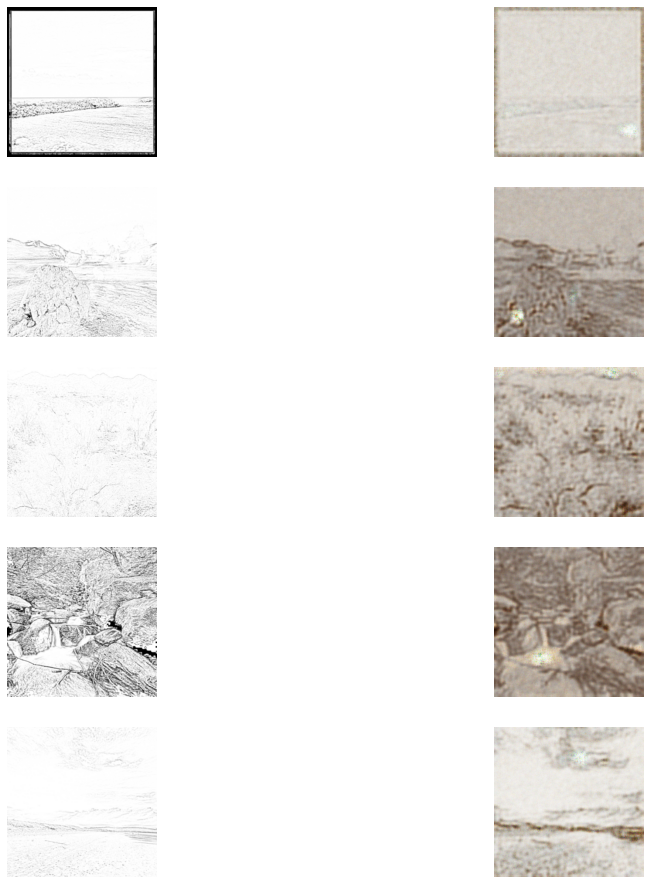

In [97]:
_, ax = plt.subplots(5, 2, figsize=(16, 16))
for i in range(5):
    photo_img, _ = next(iter(images_loader))
    pred_land = gan.gen2(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_land = unnorm(pred_land)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_land[0].permute(1, 2, 0))
    #ax[i, 0].set_title("Input Sketch Photo")
    #ax[i, 1].set_title("Landscape-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

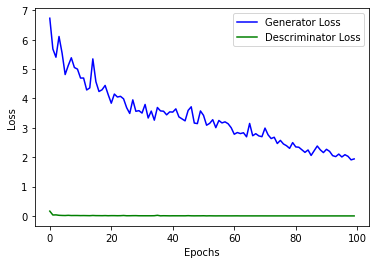

In [42]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(gan.gen_stats.losses, 'b', label='Generator Loss')
plt.plot(gan.disc_stats.losses, 'g', label='Descriminator Loss')
plt.legend()
plt.show()

In [28]:
!mkdir ../output

In [104]:
trans = transforms.ToPILImage()
for i in tqdm(range(len(images_loader))):
    photo_img, _ = next(iter(images_loader))
    with torch.no_grad():
        pred = gan.gen2(photo_img.to(device)).cpu().detach()
    pred = unnorm(pred)
    img = trans(pred[0]).convert("RGB")
    img.save("../output/" + str(i+1) + ".jpg")